# Causal Discovery with Known Causal Order in the Presence of Latent Confounders

In this notebook, we use a simple example to demonstrate how a given causal order can be used to learn a causal structure in the presence of latent confounders. The algorithm is called Ordered ICD ([OrdICD](https://arxiv.org/abs/2412.07446)), and it is based on the [ICD algorithm](https://arxiv.org/abs/2111.04095) for causal discovery in the presence of latent confounders and selection bias.  It was used to learn the causal structure from the attention mechanism in GPT (Generative Pretrained Transformer) models for Chess and Othello strategy games (see also [Rohekar et al., 2025](https://arxiv.org/abs/2412.07446)).

We assume that the true underlying causal structure is a directed acyclic graph (DAG), $\mathcal{D}(\mathbf{O}, \mathbf{L}, \mathbf{S})$, where $\mathbf{O}$, $\mathbf{L}$, and $\mathbf{S}$ represent observed variables, latent confounders, and selection variables, respectively. 
Here, a causal order is defined over the observed variables such that if $X$ precedes $Y$, then $Y$ is not an ancestor of (does not influence) $X$.

### Experiment 1: Perfect CI Oracle
The first example will follow the following steps:
1. Create a true underlying DAG and select variables to be hidden.
2. Learn a PAG using the OrdICD and ICD algorithms. A perfect oracle is used as the conditional independence test.
3. Plot the results comparing OrdICD and ICD.

Let's start by importing the required classes and methods.

In [1]:
import sys
import numpy as np
sys.path.append('..')

from causal_discovery_algs import LearnStructICD, LearnStructOrderedICD  # import causal discovery algorithms
from causal_discovery_utils.cond_indep_tests import DSep  # import the perfect oracle
from graphical_models import DAG  # import a DAG class
from plot_utils import draw_graph  # for plotting the graphs
from matplotlib import pyplot as plt

Next, let's create the true underlying DAG, a graph with 7 nodes, and define which nodes are observed.

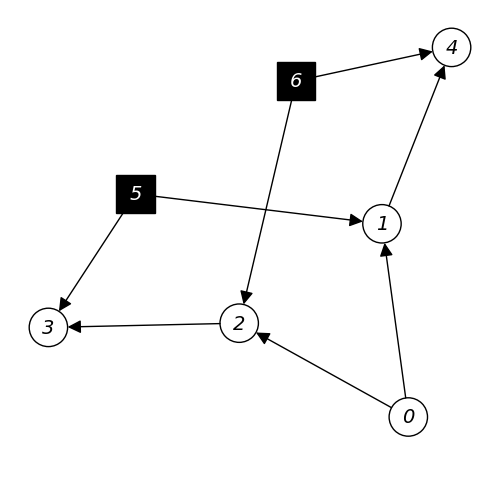

In [2]:
nodes_of_dag = set(range(7))
dag = DAG(nodes_of_dag)
dag.add_edges(parents_set={5, 0}, target_node=1)
dag.add_edges(parents_set={6, 0}, target_node=2)
dag.add_edges(parents_set={5, 2}, target_node=3)
dag.add_edges(parents_set={6, 1}, target_node=4)
observed_set = {0, 1, 2, 3, 4}  # latents set is {5, 6}
fig_dag = draw_graph(dag, latent_nodes=nodes_of_dag - observed_set)  # plot the DAG

Now, instantiate a perfect oracle, set it to count the performed CI tests, and turn on caching.

In [3]:
ci_test_dsep_icd = DSep(true_dag=dag,  # the DAG from which to read-off the true conditional independence relations
                        count_tests=True,  # count CI tests per conditioning set size
                        use_cache=True)  # make sure the same CI test is not performed and counted more than once
ci_test_dsep_ordicd = DSep(true_dag=dag,  # the DAG from which to read-off the true conditional independence relations
                           count_tests=True,  # count CI tests per conditioning set size
                           use_cache=True)  # make sure the same CI test is not performed and counted more than once

Then, learn the casual structure using the perfect oracle.

In [4]:
icd = LearnStructICD(nodes_set=observed_set, ci_test=ci_test_dsep_icd)  # instantiate ICD
icd.learn_structure()  # learn the structure using the ICD algorithm

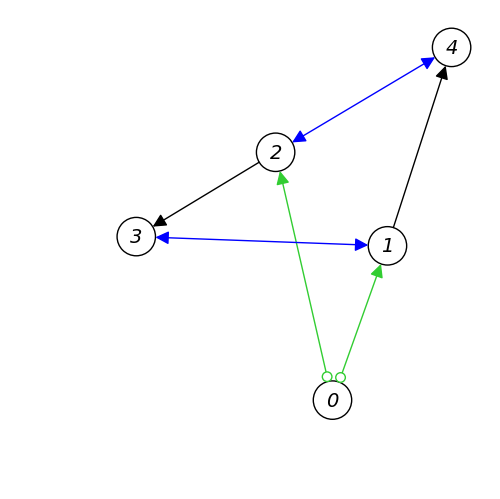

In [5]:
causal_order = [0, 1, 2, 3, 4]  # a given causal order
ordicd = LearnStructOrderedICD(nodes_set=observed_set, ci_test=ci_test_dsep_ordicd, causal_order=causal_order)  # instantiate OrdICD
ordicd.learn_structure()  # learn the structure using the OrdICD algorithm employing the given causal order
fig_pag = draw_graph(ordicd.graph)  # plot the PAG

Finally, let's plot the number of CI tests per conditioning set size.

Total number of CI tests required by ICD:    38
Total number of CI tests required by OrdICD: 26


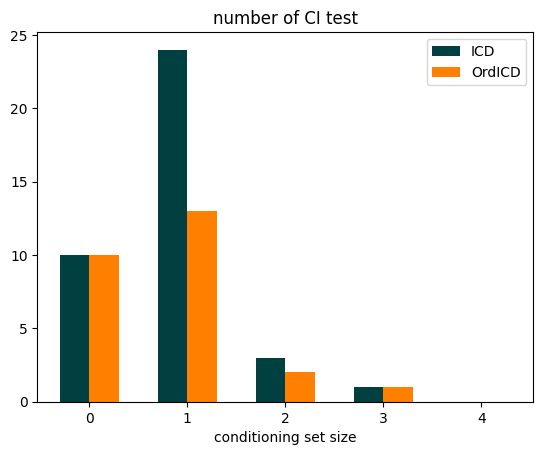

In [6]:
print('Total number of CI tests required by ICD:   ', sum(ci_test_dsep_icd.test_counter))
print('Total number of CI tests required by OrdICD:', sum(ci_test_dsep_ordicd.test_counter))
num_ci_order_to_plot = 5
ci_orders = np.array(range(num_ci_order_to_plot), dtype=float)
plt.figure()
plt.bar(ci_orders-0.15, ci_test_dsep_icd.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
        color=[0, 0.25, 0.25])
plt.bar(ci_orders+0.15, ci_test_dsep_ordicd.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
        color=[1, 0.5, 0])
plt.title('number of CI test')
plt.xlabel('conditioning set size')
plt.legend(['ICD', 'OrdICD'])
plt.show()

### Experiment 2: Sampled Graphs and Datasets
In another experiment, we examine the performance using statistical independence tests for randomly generated graphs and sampled datasets.
Here, random graphs, having linear-Gaussian parameters, are sampled, and for each graph a dataset is sampled. The conditional independence test estimates partial-correlation from the sampled dataset. Finally, the number of CI tests required by OrdICD is compared to that of ICD.

In [7]:
import random
from experiment_utils.synthetic_graphs import create_random_dag_with_latents, sample_data_from_dag
from causal_discovery_utils.performance_measures import calc_structural_accuracy_pag
from causal_discovery_utils.cond_indep_tests import CondIndepParCorr  # import a CI test that estimates partial correlation

rand_seed = 42  # arbitrary seed
random.seed(rand_seed)
np.random.seed(rand_seed)

# Properties of sampled graphs and datasets
num_nodes = 10
num_records = 1000
connectivity_coeff = 4.0
min_lin_coeff = 0.5  # minimal 'strength' of an edge
max_lin_coeff = 2.0  # maximal 'strength' of an edge
alpha = 0.01  # threshold for statistical CI tests

mean similarity of graphs learned by OrdICD to those learned by ICD (F1 score): 1.00.
mean ICD num of CI:    234
mean OrdICD num of CI: 176


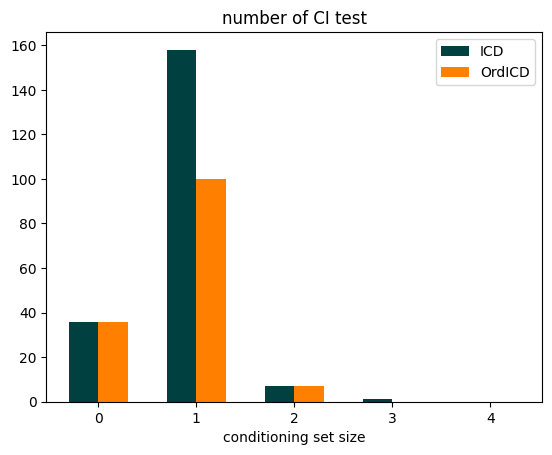

In [9]:
# Run experiment
icd_num_ci = 0
ordicd_num_ci = 0
total_similarity = 0
num_tests = 100
for exp_id in range(num_tests):
    dag, observed_set, latents_set = create_random_dag_with_latents(
        num_nodes,
        connectivity_coeff
    )
    causal_order = list(observed_set)

    dataset = sample_data_from_dag(
        dag,
        num_records,
        min_edge_weight=min_lin_coeff, max_edge_weight=max_lin_coeff
    )

    par_corr_icd = CondIndepParCorr(
        dataset=dataset,
        threshold=alpha,
        count_tests=True,
        use_cache=True
    )

    par_corr_ordicd = CondIndepParCorr(
        dataset=dataset,
        threshold=alpha,
        count_tests=True,
        use_cache=True
    )

    icd = LearnStructICD(observed_set, par_corr_icd)  # instantiate an ICD learner
    icd.learn_structure()  # learn the PAG using ICD
    learned_pag_icd = icd.graph

    ordicd = LearnStructOrderedICD(observed_set, causal_order=causal_order, ci_test=par_corr_ordicd)  # instantiate an OrdICD learner
    ordicd.learn_structure()  # learn the PAG using OrdICD
    learned_pag_ordicd = icd.graph

    # measure the difference between the graphs. There should be no difference.
    ordicd_result = calc_structural_accuracy_pag(
        pag_tested=learned_pag_ordicd,
        pag_correct=learned_pag_icd
    )

    total_similarity += ordicd_result['edge_F1']
    icd_num_ci += sum(par_corr_icd.test_counter)
    ordicd_num_ci += sum(par_corr_ordicd.test_counter)

    if ordicd_result['edge_F1'] < 1.0:
        print('F1 is not 1.0 for test #{exp_id}')

print(f'mean similarity of graphs learned by OrdICD to those learned by ICD (F1 score): {total_similarity / num_tests:.2f}.')
print(f'mean ICD num of CI:    {round(icd_num_ci / num_tests)}')
print(f'mean OrdICD num of CI: {round(ordicd_num_ci / num_tests)}')

num_ci_order_to_plot = 5
ci_orders = np.array(range(num_ci_order_to_plot), dtype=float)
plt.figure()
plt.bar(ci_orders-0.15, par_corr_icd.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
        color=[0, 0.25, 0.25])
plt.bar(ci_orders+0.15, par_corr_ordicd.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
        color=[1, 0.5, 0])
plt.title('number of CI test')
plt.xlabel('conditioning set size')
plt.legend(['ICD', 'OrdICD'])
plt.show()